# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Bayesian-Line-Identification-framework-for-WISPS-data" data-toc-modified-id="Bayesian-Line-Identification-framework-for-WISPS-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bayesian Line Identification framework for WISPS data</a></div><div class="lev2 toc-item"><a href="#Retrieve-required-data-from-aXe-products" data-toc-modified-id="Retrieve-required-data-from-aXe-products-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Retrieve required data from aXe products</a></div><div class="lev2 toc-item"><a href="#Load-redshift-estimates" data-toc-modified-id="Load-redshift-estimates-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load redshift estimates</a></div>

# Bayesian Line Identification framework for WISPS data
## Retrieve required data from aXe products
The line identification framework requires:
* A postage stamp cutout from the direct image to be used as a two-dimensional template for the line flux.
* The drizzled, wavelength calibrated, contamination-subtracted stamp for the target.

In [1]:
import os
import astropy.io.fits as astrofits
import astropy.wcs as astrowcs
from astropy.visualization import (MinMaxInterval, SqrtStretch)
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.pyplot as mplplot
import numpy as np
import scipy as sp
import scipy.stats as spstats

class StampLoader :
    
    grismToFilterMap = {102 : 110, 141 : 160}
    
    drizzledStampPathPattern = None 
    directImagePathPattern = None
    
    stampPaths = None
    stampSciHdus = None
    directPaths = None
    directHdus = None
    directCutouts = None
    
    cutoutSizePixels = None
    
    def __init__(self, 
                 drizzledStampPathPattern = '/Volumes/ramon2_wisps/data/V{pipeline_version}/Par{par}/G{grism}_DRIZZLE/aXeWFC3_G{grism}_mef_ID{object}.fits',
                 directImagePathPattern = '/Volumes/ramon2_wisps/data/V{pipeline_version}/Par{par}/DATA/DIRECT_GRISM/F{filter}.fits', 
                 cutoutSizePixels = 20) :
        self.drizzledStampPathPattern = drizzledStampPathPattern
        self.directImagePathPattern = directImagePathPattern
        self.cutoutSizePixels = cutoutSizePixels

    def getDirectFilterForGrism(self, grism):
        if grism in self.grismToFilterMap :
            return self.grismToFilterMap[grism]
        else:
            return None

    def interpolateDirectCutout(self, directData, stampHeader) :
        halfCutoutSizePixels = np.floor_divide(self.cutoutSizePixels, 2)
        refY = np.floor(stampHeader['REFPNTY'])
        refX = np.floor(stampHeader['REFPNTX'])
        cutoutLimits = ((
                int(max(0, refY - halfCutoutSizePixels)), 
                int(min(refY + halfCutoutSizePixels, directData.shape[0]))
            ),
                        (
                int(max(0, refX - halfCutoutSizePixels)), 
                int(min(refX + halfCutoutSizePixels, directData.shape[1]))
            ))
        print(halfCutoutSizePixels, directData.shape, refY, refX, cutoutLimits)
        return directImageData[cutoutLimits[0][0] : cutoutLimits[0][1], cutoutLimits[1][0] : cutoutLimits[1][1]]
        
    def extractDirectCutout(self, directData, stampHeader) :
        halfCutoutSizePixels = np.floor_divide(self.cutoutSizePixels, 2)
        refY = np.ceil(stampHeader['REFPNTY'])
        refX = np.ceil(stampHeader['REFPNTX'])
        cutoutLimits = ((
                int(max(0, refY - halfCutoutSizePixels)), 
                int(min(refY + halfCutoutSizePixels, directData.shape[0]))
            ),
                        (
                int(max(0, refX - halfCutoutSizePixels)), 
                int(min(refX + halfCutoutSizePixels, directData.shape[1]))
            ))
        print(halfCutoutSizePixels, directData.shape, refY, refX, cutoutLimits)
        return directData[cutoutLimits[0][0] : cutoutLimits[0][1], cutoutLimits[1][0] : cutoutLimits[1][1]]
        
    def loadDrizzledStamps(self, targetObject, targetPar, pipelineVersion = 6.2) :
        self.stampPaths = {102 : self.drizzledStampPathPattern.format(
                pipeline_version = pipelineVersion,
                par = targetPar,
                grism = 102,
                object = targetObject),
                      141 : self.drizzledStampPathPattern.format(
                pipeline_version = pipelineVersion,
                par = targetPar,
                grism = 141,
                object = targetObject)
                      }
                
        self.stampSciHdus = { key : (astrofits.getdata(stampPath, ext=('SCI',1), header=True) if os.path.isfile(stampPath) else None) for key, stampPath in self.stampPaths.items() }
                
    def loadDirectCutouts(self, targetObject, targetPar, pipelineVersion = 6.2) :
        if self.stampSciHdus is None :
            self.loadDrizzledStamps(targetObject, targetPar, pipelineVersion)
            
        self.directPaths = {102 : self.directImagePathPattern.format(
                pipeline_version = pipelineVersion,
                par = targetPar,
                filter = self.getDirectFilterForGrism(102)),
                      141 : self.directImagePathPattern.format(
                pipeline_version = pipelineVersion,
                par = targetPar,
                filter = self.getDirectFilterForGrism(141))
                      }
                
        self.directHdus = { key : (astrofits.getdata(directFilePath, ext=('PRIMARY', 1), header=True) if os.path.isfile(directFilePath) else None) for key, directFilePath in self.directPaths.items() }
        self.directCutouts = { key : (self.extractDirectCutout(self.directHdus[key][0], self.stampSciHdus[key][1]) if self.directHdus[key] is not None else None) for key, directHdu in self.directHdus.items() }
        
    def plotDrizzledStamps(self):
        if self.stampSciHdus is not None :
            mplplot.figure(figsize=(10,5))
            for stampIndex, (grism, hduData) in enumerate(self.stampSciHdus.items()) :
                #print (stampIndex, grism, hduData)
                stampHeader = hduData[1]
                wcsObject = astrowcs.WCS(stampHeader)
                wavelengthUnit = wcsObject.wcs.cunit[0]
                xDispUnit = wcsObject.wcs.cunit[1]
                print(wcsObject.wcs)
                mplplot.subplot(2,1,stampIndex+1, projection=wcsObject)
                mplplot.imshow(hduData[0], vmin=np.min(hduData[0]), vmax=np.max(hduData[0]), origin='lower', interpolation='none')
                mplplot.xlabel('Wavelength ({})'.format(wavelengthUnit))
                mplplot.ylabel('Cross-dispersion ({})'.format(xDispUnit))
                mplplot.title('Drizzled stamp for G{}'.format(grism))
                mplplot.grid(color='white', ls='solid')
                mplplot.tight_layout(h_pad=5.0)
        else :
            print('The loadDrizzledStamps(...) method must be called before drizzled stamps can be plotted.')
            
    def plotDirectCutouts(self):
        if self.directCutouts is not None :
            mplplot.figure(figsize=(10,5))
            for stampIndex, (grism, cutoutData) in enumerate(self.directCutouts.items()) :
                mplplot.subplot(2,1,stampIndex+1)
                mplplot.imshow(cutoutData, vmin=np.min(cutoutData), vmax=np.max(cutoutData), origin='lower', interpolation='none')
                mplplot.xlabel('X (pixels)')
                mplplot.ylabel('Y (pixels)')
                mplplot.title('Direct cutout for F{} (G{})'.format(self.getDirectFilterForGrism(grism), grism))
                mplplot.grid(color='white', ls='solid')
                mplplot.tight_layout()
        else :
            print('The loadDirectCutouts(...) method must be called before direct cutouts can be plotted.')
        
    def getDrizzledStampData(self, grism) :
        if self.stampSciHdus is not None :
            return self.stampSciHdus[grism][0] if self.stampSciHdus[grism] is not None else None
        else :
            print('The loadDrizzledStamps(...) method must be called before drizzled stamp data can be returned.')
            
    def getDrizzledStampHeader(self, grism) :
        if self.stampSciHdus is not None :
            return self.stampSciHdus[grism][1] if self.stampSciHdus[grism] is not None else None
        else :
            print('The loadDrizzledStamps(...) method must be called before drizzled stamp header can be returned.')
            
    def getDirectCutout(self, grism) :
        if self.directCutouts is not None :
            return self.directCutouts[grism] if self.directCutouts[grism] is not None else None
        else :
            print('The loadDirectCutouts(...) method must be called before direct cutouts can be returned.')
        
    def getThresholdedDirectCutout(self, grism) :
        skyKeyword = 'MDRIZSKY'
        if self.directHdus is not None :
            return self.directHdus[grism][1][skyKeyword]
        else :
            print('The loadDirectCutouts(...) method must be called before sky-subtracted direct cutouts can be returned.')


       flag: 137
      naxis: 2
      crpix: 0x7f892e574cb0
               15.000       33.000    
         pc: 0x7f892e1b16d0
    pc[0][]:   1.0000       0.0000    
    pc[1][]:   0.0000       1.0000    
      cdelt: 0x7f892e1b16f0
               4.6500e-09   0.12825   
      crval: 0x7f892e1b0d30
               1.0100e-06   0.0000    
      cunit: 0x7f892e1eb450
             "m"
             "arcsec"
      ctype: 0x7f892e53b840
             "WAVE"
             "CRDIST"
    lonpole: UNDEFINED
    latpole: 90.000000
    restfrq: 0.000000
    restwav: 0.000000
        npv: 0
     npvmax: 0
         pv: 0x0
        nps: 0
     npsmax: 0
         ps: 0x0
         cd: 0x7f892e560220
    cd[0][]:   0.0000       0.0000    
    cd[1][]:   0.0000       0.0000    
      crota: 0x7f892e558240
               0.0000       0.0000    
     altlin: 0
     velref: 0
        alt: ' '
     colnum: 0
      colax: 0x7f892e1b61b0
                 0      0
    wcsname: UNDEFINED
      cname: 0x7f892e598c30


0.7963426113128662

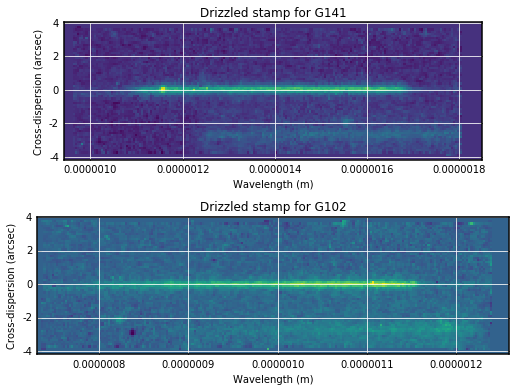

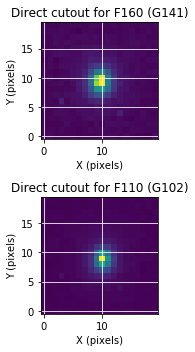

In [2]:
%matplotlib inline 
sl = StampLoader()
sl.loadDrizzledStamps(16, '302_MB')
sl.plotDrizzledStamps()
sl.loadDirectCutouts(16, '302_MB')
sl.plotDirectCutouts()
sl.getThresholdedDirectCutout(141)

## Load redshift estimates

In [3]:
estimateFileName = '/Users/hughdickinson/Documents/Development/WISPSBayesianLineID/Par302_estimates.fits'
estimateFile = astrofits.open(estimateFileName)
estimateFile.info()

Filename: /Users/hughdickinson/Documents/Development/WISPSBayesianLineID/Par302_estimates.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       4   ()      
  1              BinTableHDU     24   668R x 8C   [K, D, D, 3K, 28A, D, 331D, L]   


In [4]:
estimateTable = estimateFile[1].data
print(estimateTable.columns)

ColDefs(
    name = 'target'; format = 'K'
    name = 'redshift'; format = 'D'
    name = 'redshift_err'; format = 'D'
    name = 'ews'; format = '3K'
    name = 'model'; format = '28A'
    name = 'normalization'; format = 'D'
    name = 'probability'; format = '331D'
    name = 'has_line'; format = 'L'
)
